# Import Library & CSV

In [459]:
!gdown --id 1QPWiTnxCb5td5o5WzWwCZhyzp9ziLBb0
!pip install transformers
!pip install datasets

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QPWiTnxCb5td5o5WzWwCZhyzp9ziLBb0
To: /content/clean_data.csv
100% 82.9k/82.9k [00:00<00:00, 32.5MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [460]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from datasets import load_metric

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np

In [461]:
df = pd.read_csv('clean_data.csv')

In [462]:
df.replace("", float("NaN"), inplace=True)
df.dropna(inplace=True)

df = df[['data', 'label']]

In [463]:
df.sample(5)

,data,label
382,netizen indonesia ngehujat enggak hubung ambil...,Non_Misogyny
787,cantik,Non_Misogyny
43,coba makan peluru pelor seru tuju like,Misogyny
155,rinduh balas,Non_Misogyny
493,cantik wanita cantik agama cantik agama cantik...,Non_Misogyny


In [464]:
# df = df.sample(13000)

In [465]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1213 entries, 0 to 1212
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    1213 non-null   object
 1   label   1213 non-null   object
dtypes: object(2)
memory usage: 28.4+ KB


# Eksplorasi & Split Dataset

In [466]:
def show_plot(df):
  plt.figure(figsize=(5, 5))
  sns.countplot(x=df['label'])

  orange_patch = mpatches.Patch(color='tab:orange', label='misogyny')
  blue_patch = mpatches.Patch(color='tab:blue', label='non misogyny')
  plt.legend(handles=[orange_patch, blue_patch])

  plt.show()

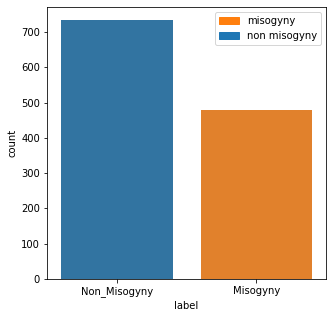

In [467]:
show_plot(df)

In [468]:
def oversample(df):
    classes = df.label.value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['label'] == key]) 
    classes_sample = []
    for i in range(1,len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

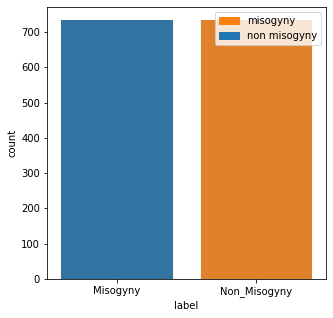

In [469]:
df = oversample(df)
show_plot(df)

## Data Splitting

In [470]:
df["label"] = df["label"].map({'Non_Misogyny': 0, 'Misogyny': 1})

In [471]:
RANDOM_SEED = 30

df_train, df_test = train_test_split(
    df,
    test_size=0.3,
    random_state=RANDOM_SEED,
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.4,
    random_state=RANDOM_SEED,
)

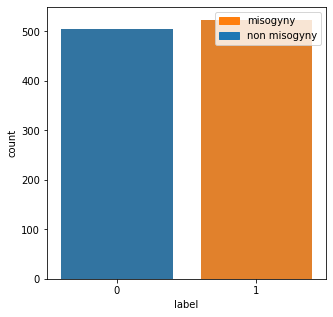

In [472]:
show_plot(df_train)

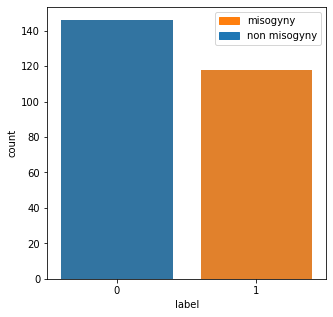

In [473]:
show_plot(df_val)

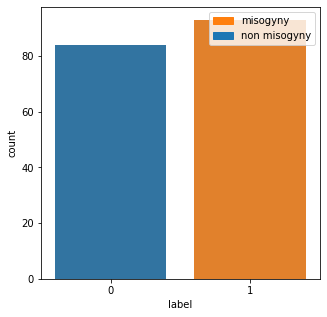

In [474]:
show_plot(df_test)

In [475]:
print(f'Total Train: {len(df_train)}')
print(f'Total Val  : {len(df_val)}')
print(f'Total Test : {len(df_test)}')

Total Train: 1027
Total Val  : 264
Total Test : 177


# 

In [476]:
actual_label = df_test['label']

In [477]:
df_train.to_csv("train.csv", index=False)
df_val.to_csv("eval.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [478]:
from datasets import load_dataset

files = {
    "train": "train.csv", 
    "eval": "eval.csv", 
    "test": "test.csv",
}

dataset = load_dataset('csv', data_files=files)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-ad17aea7bb7dc2f0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Tokenize Dataset

In [479]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
# tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--indobenchmark--indobert-base-p2/snapshots/94b4e0a82081fa57f227fcc2024d1ea89b57ac1f/config.json
Model config BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p2",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "

In [480]:
def tokenize_function(text):
  return tokenizer(text["data"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [481]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

# Train

In [482]:
import torch
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [483]:
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=2)
# model = AutoModelForSequenceClassification.from_pretrained("indolem/indobertweet-base-uncased", num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--indobenchmark--indobert-base-p2/snapshots/94b4e0a82081fa57f227fcc2024d1ea89b57ac1f/config.json
Model config BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p2",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size

In [484]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "test_trainer", 
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=3e-6,
    logging_steps=200,
    evaluation_strategy="steps", 
)

using `logging_steps` to initialize `eval_steps` to 200
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

training_history = trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1027
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 650


Step,Training Loss,Validation Loss,Accuracy
200,0.519100,0.463548,0.787879
400,0.255900,0.482228,0.806818


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 264
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 264
  Batch size = 16
Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin


# Evaluate

In [ ]:
plt.plot([1, 0.296600, 0.254100, 0.231800], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([0, 1, 2, 3])
plt.show()

In [ ]:
evaluation_history = trainer.evaluate()
evaluation_history

In [ ]:
test_dataset = tokenized_datasets["test"]

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

In [ ]:
print(classification_report(prediction, actual_label, target_names=["non misogyny", "misogyny"]))

In [ ]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

cm = confusion_matrix(prediction, actual_label)
show_confusion_matrix(cm)

# save model

In [ ]:
model.save_pretrained("model")

In [ ]:
trainer = Trainer(model=model)

In [ ]:
from numpy.ma.core import exp
def logits_converter(logits):
  odds = exp(logits)
  return odds / (1 + odds)

In [ ]:
def predict(text):
    tokenized = tokenizer(text, padding='max_length', max_length=256)
    all_label = trainer.predict([tokenized],).predictions
    label = all_label.argmax(1)[0]
    if label == 0:
        print(f'Predicted: Negatif [{label}]')
    else:
        print(f'Predicted: Positif [{label}]')
    
    print('non misogyny : ', logits_converter(all_label[0][0]))
    print('misogyny : ', logits_converter(all_label[0][1]))

In [ ]:
predict("""
    dasar cewek lonte memeklu
""")

In [ ]:
predict("""
    tolong ya ges sesama cewe jangan saling menyalahkan okayy
""")